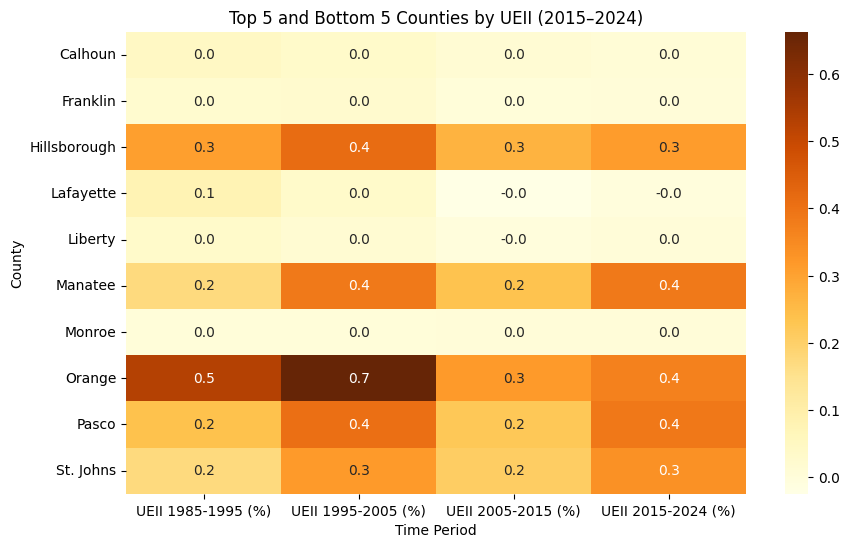

    S.N.        County  County Area (sq mi)  Developed Area 1985 (sq mi)  Developed Area 1995 (sq mi)  Developed Area 2005 (sq mi)  Developed Area 2015 (sq mi)  Developed Area 2024 (sq mi)  UEII 1985-1995 (%)  UEII 1995-2005 (%)  UEII 2005-2015 (%)  UEII 2015-2024 (%)
0      1       Wakulla             736.5335                      29.9469                      33.6212                      38.1216                      40.1324                      43.1760              0.0499              0.0611              0.0273              0.0459
1      2     Jefferson             637.2036                      23.7893                      25.5653                      26.8942                      27.3064                      28.1511              0.0279              0.0209              0.0065              0.0147
2      3       Gadsden             529.0682                      36.8055                      39.8032                      43.9973                      45.8703                      47.2149     

In [1]:
import ee
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# --- 1. SETUP ---
nlcd_collection = ee.ImageCollection("projects/sat-io/open-datasets/USGS/ANNUAL_NLCD/LANDCOVER")
target_years = [1985, 1995, 2005, 2015, 2024]
developed_classes = [21, 22, 23, 24]
scale = 30
sqm_to_sqmi = 3.86102159e-7

nlcd_images = ee.Dictionary({
    year: nlcd_collection.filter(ee.Filter.eq('year', year)).first().select('b1')
    for year in target_years
})

counties_collection = ee.FeatureCollection("TIGER/2018/Counties")
florida_counties = counties_collection.filter(ee.Filter.eq('STATEFP', '12'))

# --- 2. FUNCTIONS ---
def calculate_developed_area(image, geometry):
    mask = image.remap(developed_classes, [1] * len(developed_classes), 0).selfMask()
    area_image = mask.multiply(ee.Image.pixelArea()).rename('area')
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e13
    )
    return ee.Number(stats.get('area')).multiply(sqm_to_sqmi)

def compute_ueii(area_t1, area_t2, delta_t, total_area):
    return (ee.Number(area_t2).subtract(area_t1)
            .divide(ee.Number(total_area).multiply(delta_t))).multiply(100)

def analyze_county(feature):
    geom = feature.geometry()
    county_area_sqmi = ee.Number(geom.area(maxError=1)).multiply(sqm_to_sqmi)
    dev_areas = ee.Dictionary({
        str(year): calculate_developed_area(ee.Image(nlcd_images.get(str(year))), geom)
        for year in target_years
    })
    ueii_85_95 = compute_ueii(dev_areas.get('1985'), dev_areas.get('1995'), 10, county_area_sqmi)
    ueii_95_05 = compute_ueii(dev_areas.get('1995'), dev_areas.get('2005'), 10, county_area_sqmi)
    ueii_05_15 = compute_ueii(dev_areas.get('2005'), dev_areas.get('2015'), 10, county_area_sqmi)
    ueii_15_24 = compute_ueii(dev_areas.get('2015'), dev_areas.get('2024'), 9, county_area_sqmi)
    return feature.set({
        'County Area (sq mi)': county_area_sqmi,
        'Developed Area 1985 (sq mi)': dev_areas.get('1985'),
        'Developed Area 1995 (sq mi)': dev_areas.get('1995'),
        'Developed Area 2005 (sq mi)': dev_areas.get('2005'),
        'Developed Area 2015 (sq mi)': dev_areas.get('2015'),
        'Developed Area 2024 (sq mi)': dev_areas.get('2024'),
        'UEII 1985-1995 (%)': ueii_85_95,
        'UEII 1995-2005 (%)': ueii_95_05,
        'UEII 2005-2015 (%)': ueii_05_15,
        'UEII 2015-2024 (%)': ueii_15_24
    })

# --- 3. BATCH PROCESSING ---
county_list = florida_counties.toList(florida_counties.size())
batch_size = 5
n_counties = florida_counties.size().getInfo()

all_features = []
for start in range(0, n_counties, batch_size):
    subset = ee.FeatureCollection(county_list.slice(start, start + batch_size))
    subset_results = subset.map(analyze_county).getInfo()
    all_features.extend(subset_results['features'])

# --- 4. BUILD DATAFRAME ---
data_for_df = []
for i, feature in enumerate(all_features):
    props = feature['properties']
    row_data = {'S.N.': i + 1, 'County': props['NAME']}
    row_data.update(props)
    data_for_df.append(row_data)

df = pd.DataFrame(data_for_df)
final_columns = [
    'S.N.', 'County', 'County Area (sq mi)',
    'Developed Area 1985 (sq mi)', 'Developed Area 1995 (sq mi)',
    'Developed Area 2005 (sq mi)', 'Developed Area 2015 (sq mi)',
    'Developed Area 2024 (sq mi)', 'UEII 1985-1995 (%)',
    'UEII 1995-2005 (%)', 'UEII 2005-2015 (%)', 'UEII 2015-2024 (%)'
]
df = df[final_columns].round(4)

# --- 5. HEATMAP: Top 5 & Bottom 5 by UEII 2015–2024 ---
top5 = df.nlargest(5, 'UEII 2015-2024 (%)')
bottom5 = df.nsmallest(5, 'UEII 2015-2024 (%)')
heatmap_df = pd.concat([top5, bottom5])

# Melt for heatmap
heatmap_long = heatmap_df.melt(
    id_vars=['County'],
    value_vars=[
        'UEII 1985-1995 (%)',
        'UEII 1995-2005 (%)',
        'UEII 2005-2015 (%)',
        'UEII 2015-2024 (%)'
    ],
    var_name='Time Period',
    value_name='UEII (%)'
)

# Pivot for plotting
heatmap_data = heatmap_long.pivot(index='County', columns='Time Period', values='UEII (%)')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlOrBr')
plt.title('Top 5 and Bottom 5 Counties by UEII (2015–2024)')
plt.xlabel('Time Period')
plt.ylabel('County')
plt.show()

# --- 6. CHOROPLETH MAP FOR ALL COUNTIES ---
# Get Florida counties GeoJSON
fl_counties_geo = florida_counties.getInfo()

# Create DataFrame from GeoJSON features
geo_df = pd.DataFrame([
    {
        'County': f['properties']['NAME'],
        'geometry': f['geometry']
    }
    for f in fl_counties_geo['features']
])

# Merge with UEII data
merged_df = geo_df.merge(df, on='County')

# Create map
m = folium.Map(location=[27.9944024, -81.7602544], zoom_start=7)

# Add choropleth
folium.Choropleth(
    geo_data={"type": "FeatureCollection", "features": fl_counties_geo['features']},
    data=merged_df,
    columns=['County', 'UEII 2015-2024 (%)'],
    key_on='feature.properties.NAME',
    fill_color='YlOrBr',  # red-brownish palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='UEII 2015-2024 (%)'
).add_to(m)

# Add county name labels
for _, row in merged_df.iterrows():
    centroid = ee.Geometry(row['geometry']).centroid().getInfo()['coordinates']
    folium.Marker(
        location=[centroid[1], centroid[0]],
        popup=row['County'],
        icon=folium.DivIcon(html=f"""<div style="font-size:8pt; text-align:center">{row['County']}</div>""")
    ).add_to(m)

m.save('choropleth_map.html')

print(df.to_string())
